<a href="https://colab.research.google.com/github/Shiv-am-19/Stock-Price-Predictive-Using-AI-model/blob/main/Stock_uber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


In [2]:
company = 'UBER'
stock_data = pd.read_csv("UBER stock.csv", parse_dates=['Date'], sep=',', index_col='Date')


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500
2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400
2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100
2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100
2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500
...,...,...,...,...,...,...
2022-03-18,32.520000,33.419998,32.330002,33.360001,33.360001,35779700
2022-03-21,32.820000,32.820000,31.250000,31.980000,31.980000,35200600
2022-03-22,31.930000,33.599998,31.840000,33.349998,33.349998,21852800



# **Plotting UBER stock closing prices**

Text(0.5, 1.0, 'UBER stock closing prices')

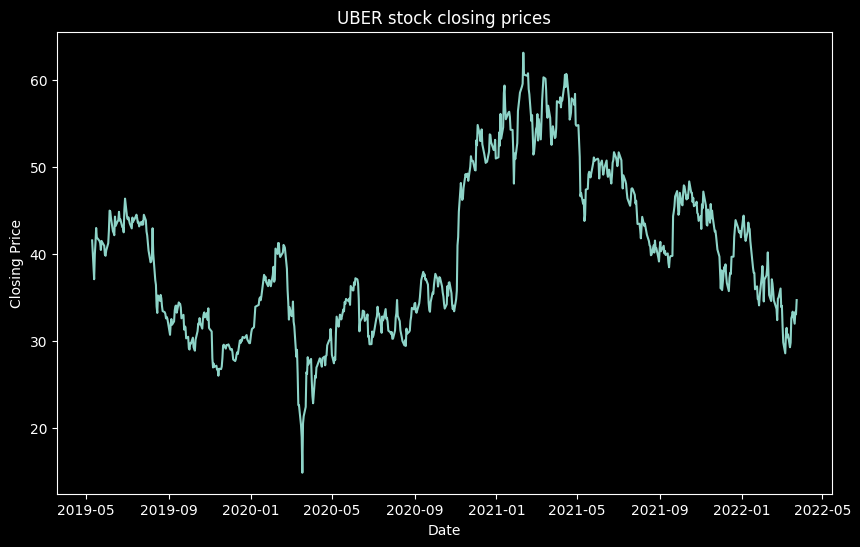

In [4]:
df_close = stock_data['Close']
plt.style.use('dark_background')
plt.figure(figsize=(10,6))
# plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('UBER stock closing prices')

In [5]:
def test_stationarity(timeseries):

  rolmean = timeseries.rolling(20).mean()
  rolstd = timeseries.rolling(20).std()

  orig = plt.plot(timeseries, color = 'Blue', label = 'Original')
  mean = plt.plot(rolmean, color = 'Red', label = 'Rolling Mean')
  std = plt.plot(rolstd, color = 'Black', label = 'Rolling Std')
  plt.legend(loc = 'best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block = False)

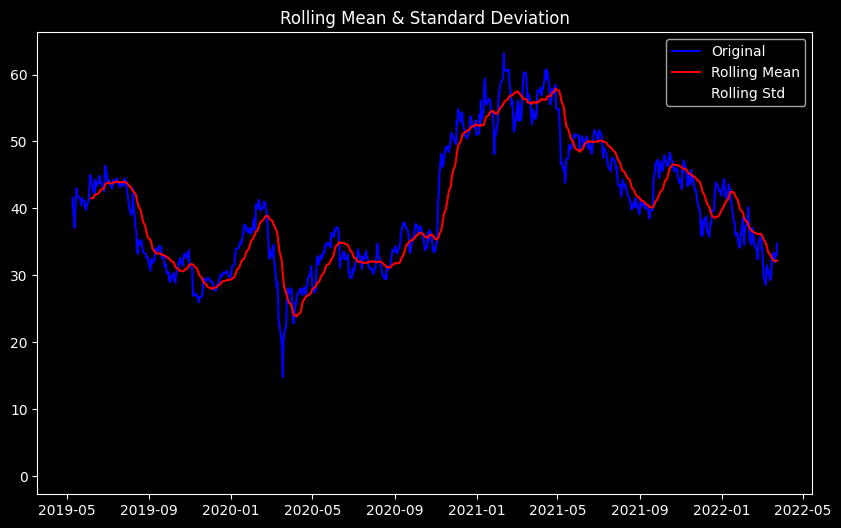

In [6]:
plt.figure(figsize=(10,6))
test_stationarity(df_close.head(2000))

In [7]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df_close.head(2000), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.044689
p-value                          0.267329
#Lags Used                       2.000000
Number of Observations Used    722.000000
Critical Value (1%)             -3.439440
Critical Value (5%)             -2.865551
Critical Value (10%)            -2.568906
dtype: float64


<Figure size 640x480 with 0 Axes>

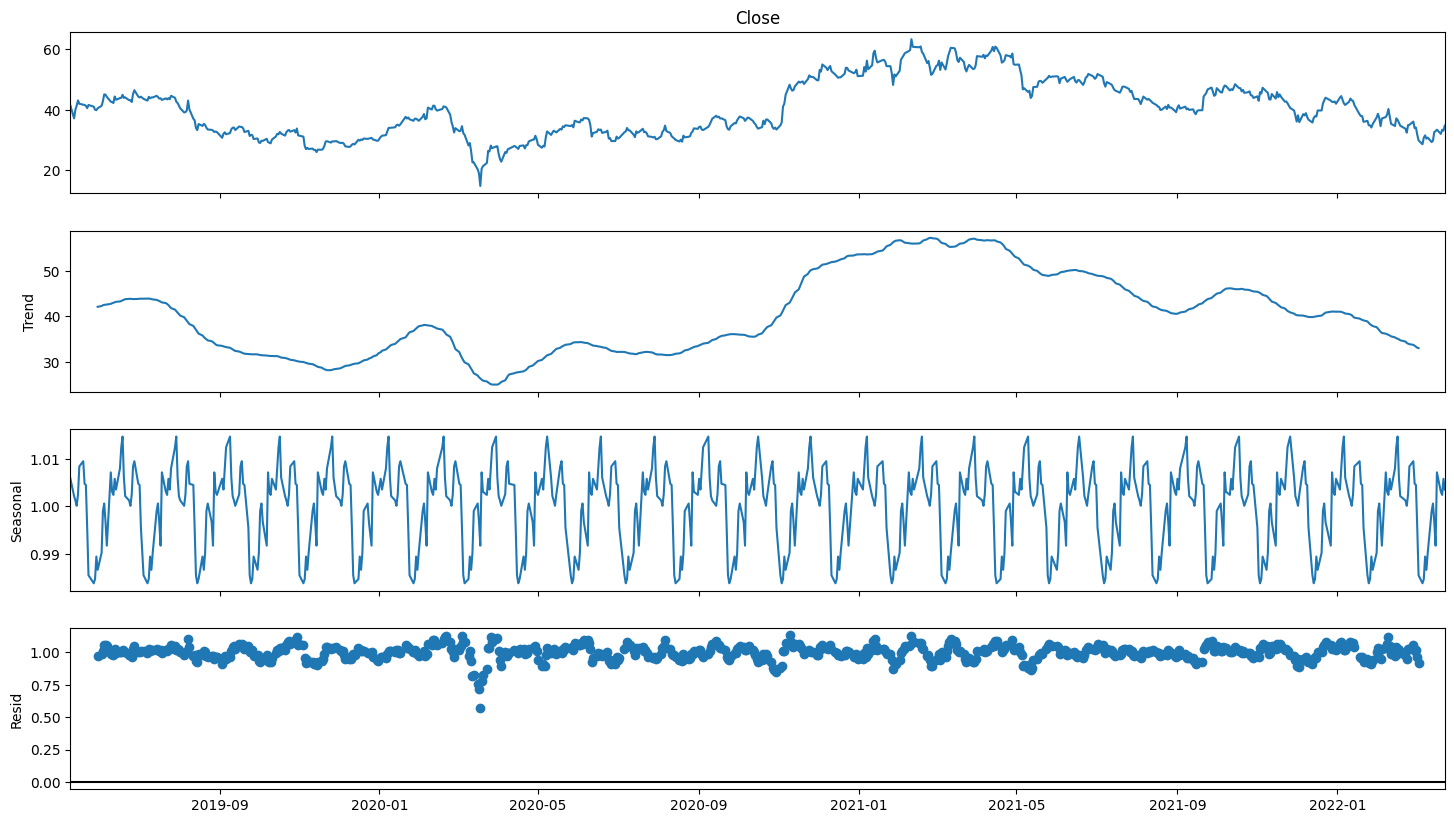

In [8]:
plt.style.use('default')
result = seasonal_decompose(df_close, model = 'multiplicative', period = 28)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16,9)

Text(0.5, 1.0, 'Tranformed data')

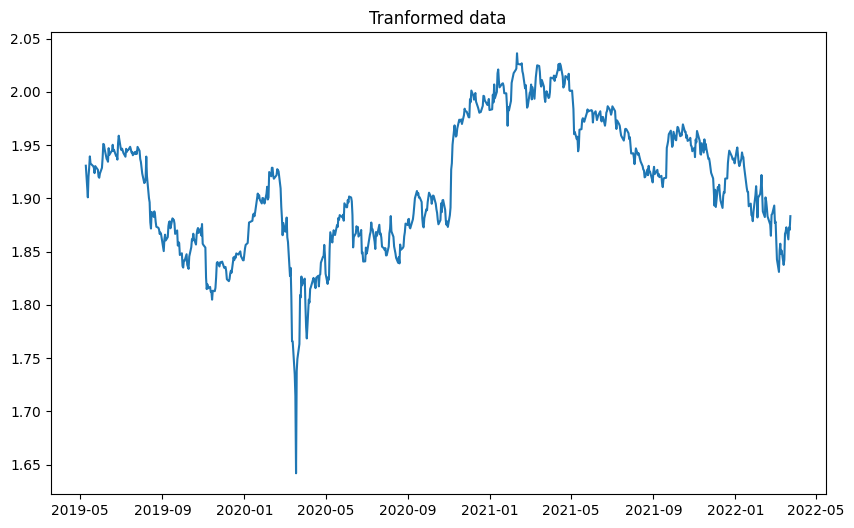

In [9]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)
plt.style.use('default')
plt.figure(figsize=(10,6))
plt.plot(df_close_tf)
plt.title('Tranformed data')

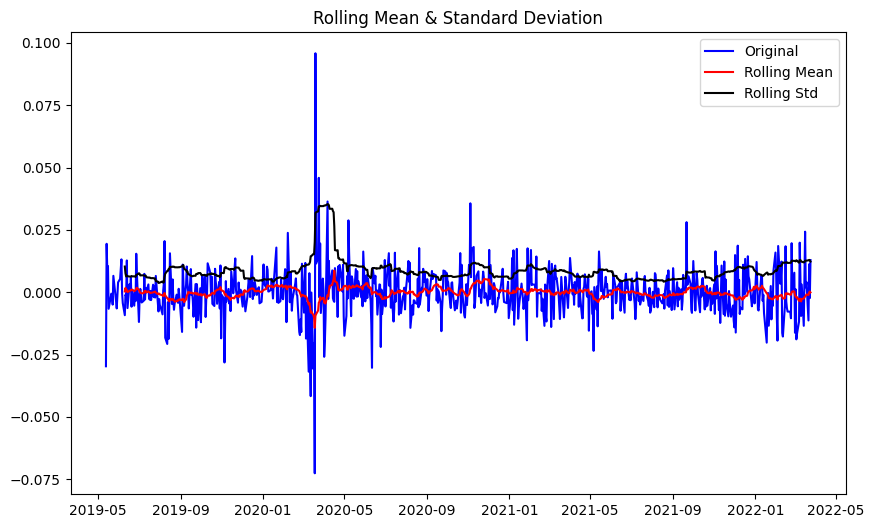

In [10]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

In [11]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df_close_shift.head(2000), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.517646e+00
p-value                        3.865103e-11
#Lags Used                     1.100000e+01
Number of Observations Used    7.120000e+02
Critical Value (1%)           -3.439568e+00
Critical Value (5%)           -2.865608e+00
Critical Value (10%)          -2.568936e+00
dtype: float64


In [12]:
def preprocess_lstm(sequence, n_steps, n_features):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix >= len(sequence):
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)

  X = np.array(X)
  y = np.array(y)

  X = X.reshape((X.shape[0], X.shape[1], n_features))
  return X,y

## **Selecting Prediction timeframe in days**

In [13]:
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

# **Divide the dataset into training and test sets**

In [14]:
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[:-test_days:]

In [15]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

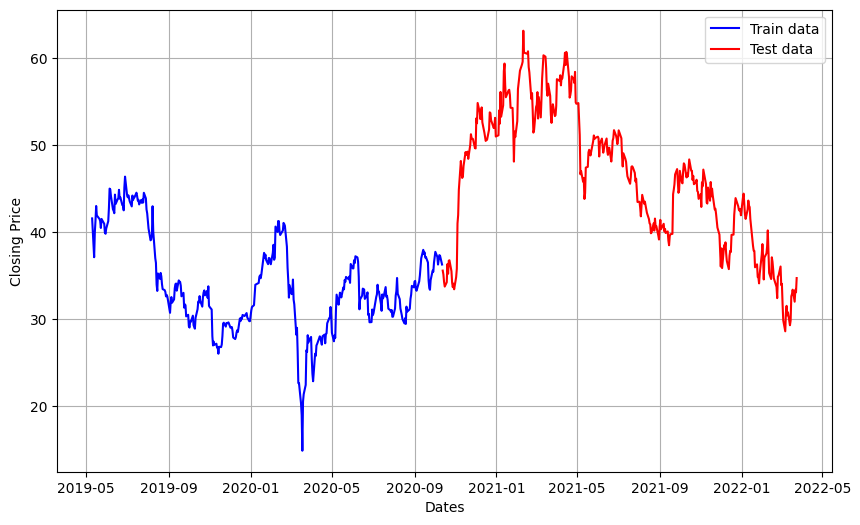

In [16]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.plot(train_original, 'b', label = 'Train data')
plt.plot(test_original, 'r', label = 'Test data')
plt.legend()

In [17]:
def vanilla_LSTM():
  model = Sequential()
  model.add(LSTM(units =50, input_shape = (nb_days, n_features)))
  model.add(Dense(1))
  return model

In [18]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics = [tf.keras.metrics.MeanAbsoluteError])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(X_train, y_train, epochs = 15,batch_size = 32)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.2704e-04 - mean_absolute_error: 0.0082
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.6081e-04 - mean_absolute_error: 0.0082
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4240e-04 - mean_absolute_error: 0.0076
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8567e-04 - mean_absolute_error: 0.0075
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6289e-04 - mean_absolute_error: 0.0076
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4254e-04 - mean_absolute_error: 0.0074
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3808e-04 - mean_absolute_error: 0.0074
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2412e-04 - mean_absolute_error: 0.0071
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5365e-04 - mean_absolute_error: 0.0078
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4700e-04 - mean_absolute_error: 0.0078

# **Evaluating the model using test data**

In [20]:
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (365, 60, 1)
Shape of y_test: (299,)


In [21]:
x_test = np.random.rand(365, 10)
y_test = np.random.rand(299)

if len(x_test) != len(y_test):
    min_len = min(len(x_test), len(y_test))
    X_test= x_test[:min_len]
    y_test = y_test[:min_len]

print(f'x shape: {x_test.shape}')
print(f'y shape: {y_test.shape}')


x shape: (365, 10)
y shape: (299,)


In [22]:
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (299, 10)
Shape of y_test: (299,)


In [23]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3115 - mean_absolute_error: 0.4816  
Test MSE: 0.31235572695732117
Test MAE: 0.48534324765205383


# **Prediction Analysis**

In [24]:
x_test = np.random.rand(365, 10)     # 365 samples, 10 features each
y_test = np.random.rand(299)   # 299 target values

# Ensure x and y have the same number of samples
if len(x_test) != len(y_test):
    min_len = min(len(x_test), len(y_test))
    X_test= x_test[:min_len]
    y_test = y_test[:min_len]

print(f'x shape: {x_test.shape}')
print(f'y shape: {y_test.shape}')


x shape: (365, 10)
y shape: (299,)


In [25]:
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (299, 10)
Shape of y_test: (299,)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


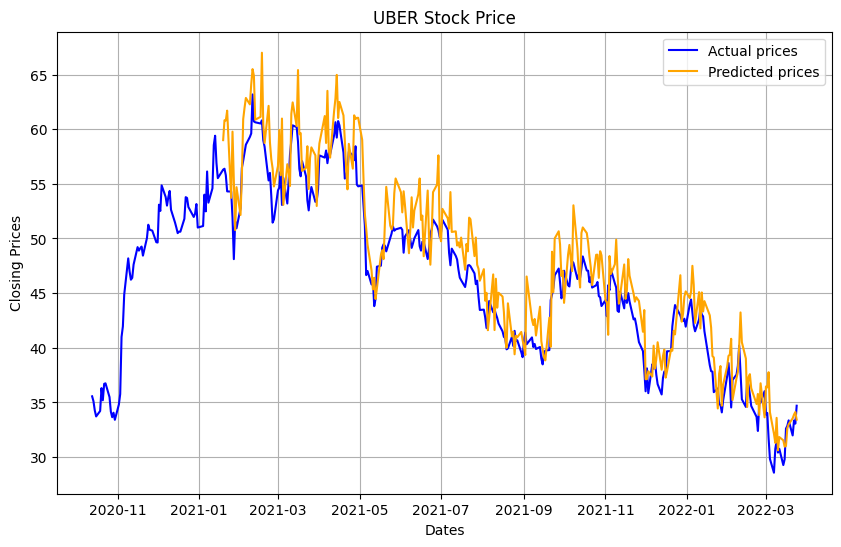

In [26]:
y_pred = model.predict(X_test)

pred_data = pd.DataFrame(y_pred[:,0], index=df_close_tf.index[-len(y_pred):], columns=['Close'])

pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-len(pred_data):]

pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title(company + ' Stock Price')
plt.legend()

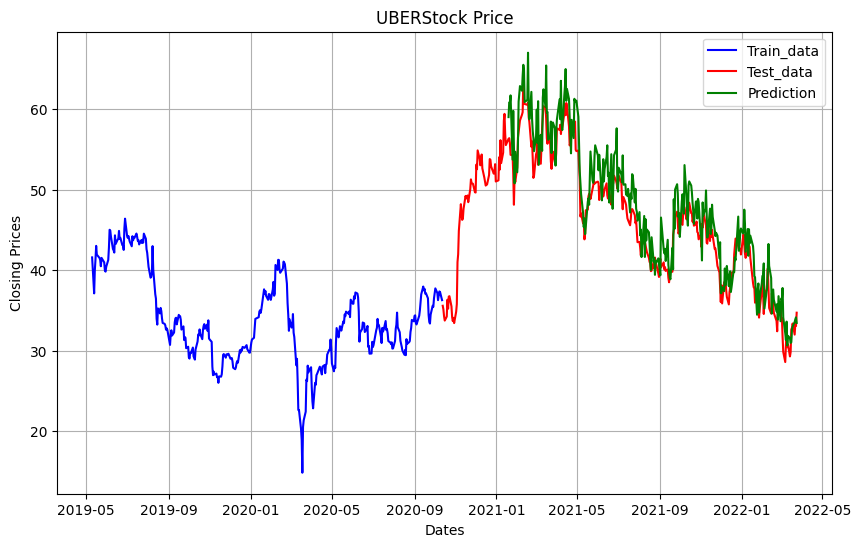

In [27]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label = 'Train_data')
plt.plot(test_original, 'r', label = 'Test_data')
plt.plot(pred_data, 'g', label = 'Prediction')
plt.title(company + 'Stock Price')
plt.legend()

In [28]:
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, n_features):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)

  X = np.array(X)
  y = np.array(y)

  X = X.reshape((X.shape[0], X.shape[1], n_features))

  return X, y

# **Time Horizon for Future Prediction compared to the Historical Basis**

In [29]:
n_steps_out = 10
nb_days = 60
n_features  = 1
X,y = preprocess_multistep_lstm(df_close_shift.to_numpy(), nb_days, n_steps_out, n_features)

# **Split the data set between the training set & the test set**

In [30]:
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

In [31]:
def vanilla_multistep_LSTM():
  model = Sequential()
  model.add(LSTM(units =50, input_shape = (nb_days, n_features)))
  model.add(Dense(n_steps_out))
  return model

In [32]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer='adam',loss='mean_squared_error',metrics=[tf.keras.metrics.MeanAbsoluteError()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,910 (42.62 KB)

 Trainable params: 10,910 (42.62 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.fit(X_train, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.4106e-04 - mean_absolute_error: 0.0076
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2964e-04 - mean_absolute_error: 0.0075
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4872e-04 - mean_absolute_error: 0.0077
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6009e-04 - mean_absolute_error: 0.0078
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.2087e-04 - mean_absolute_error: 0.0072
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.2857e-04 - mean_absolute_error: 0.0072
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.6028e-04 - mean_absolute_error: 0.0078
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.5028e-04 - mean_absolute_error: 0.0077
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.4343e-04 - mean_absolute_error: 0.0074
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4210e-04 - mean_absolute_error: 0.0075

In [34]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])



Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0359e-05 - mean_absolute_error: 0.0064
Test MSE: 7.085381366778165e-05
Test MAE: 0.0065190354362130165


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


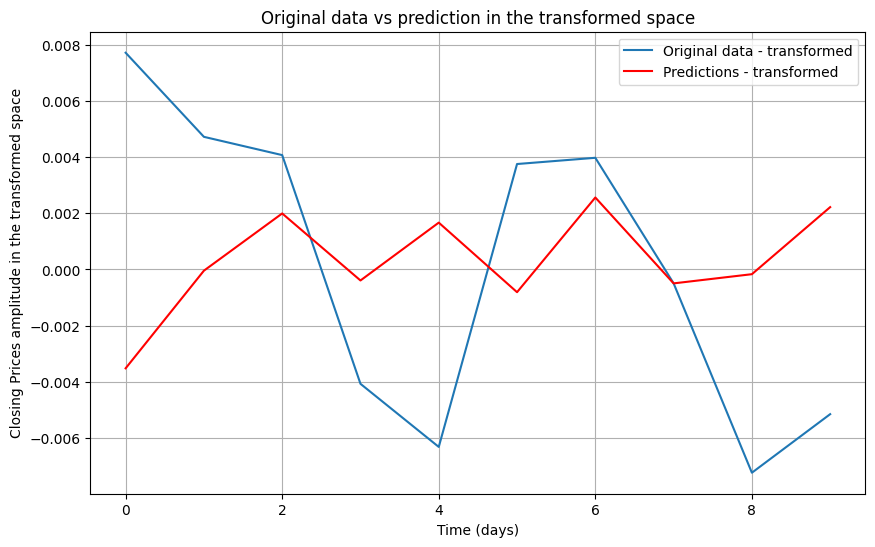

In [35]:
y_pred = model.predict(X_test)

the_day = 0
y_pred_data = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:], label='Original data - transformed')
plt.plot(y_pred_data,color='red', label ='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Closing Prices amplitude in the transformed space')
plt.title('Original data vs prediction in the transformed space')
plt.legend()

In [36]:
pred_diff_cumsum = y_pred_data.cumsum()

base_number = df_close_tf.values[-test_days + the_day+nb_days-1]
idx = test_original.iloc [the_day:the_day+n_steps_out].index

pred_tf = pd.Series(base_number, index = idx)
pred_tf = pred_tf.add(pred_diff_cumsum, fill_value = 0)

print(pred_tf)

Date
2020-10-13    2.003387
2020-10-14    2.003344
2020-10-15    2.005338
2020-10-16    2.004946
2020-10-19    2.006614
2020-10-20    2.005805
2020-10-21    2.008367
2020-10-22    2.007872
2020-10-23    2.007703
2020-10-26    2.009922
dtype: float64


In [37]:
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

Date
2020-10-13    55.343529
2020-10-14    55.334003
2020-10-15    55.778065
2020-10-16    55.690517
2020-10-19    56.064309
2020-10-20    55.882686
2020-10-21    56.460299
2020-10-22    56.348082
2020-10-23    56.310012
2020-10-26    56.814221
dtype: float64


# **Plotting Actual prices vs Predicted prices for Sell Point**

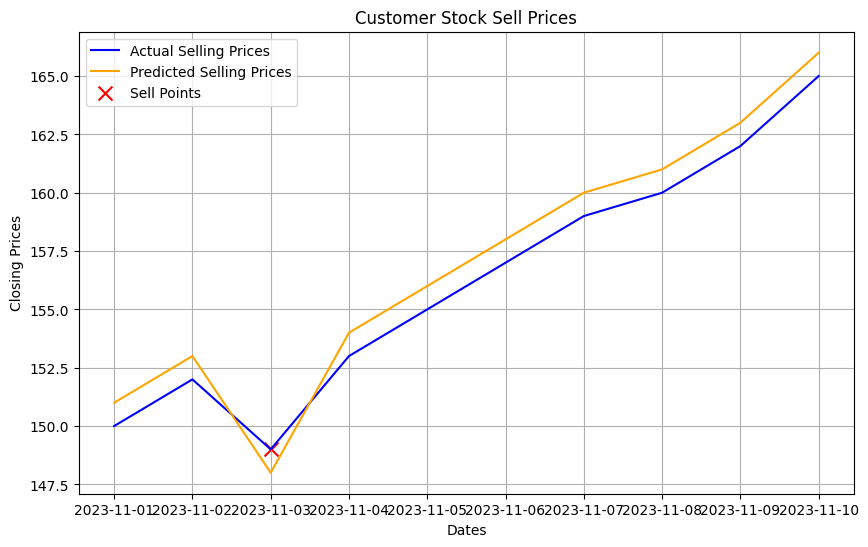

In [38]:
dates = pd.date_range(start='2023-11-01', periods=10, freq='D')
actual_prices = [150, 152, 149, 153, 155, 157, 159, 160, 162, 165]
predicted_prices = [151, 153, 148, 154, 156, 158, 160, 161, 163, 166]

sell_condition = [actual > predicted for actual, predicted in zip(actual_prices, predicted_prices)]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')

plt.plot(dates, actual_prices, 'b', label='Actual Selling Prices')
plt.plot(dates, predicted_prices, 'orange', label='Predicted Selling Prices')

sell_dates = [date for date, sell in zip(dates, sell_condition) if sell]
sell_prices = [price for price, sell in zip(actual_prices, sell_condition) if sell]
plt.scatter(sell_dates, sell_prices, color='red', marker='x', s=100, label='Sell Points')

plt.title('Customer Stock Sell Prices')
plt.legend()
plt.show()


# **Plotting Actual prices vs Predicted prices for Buy point**


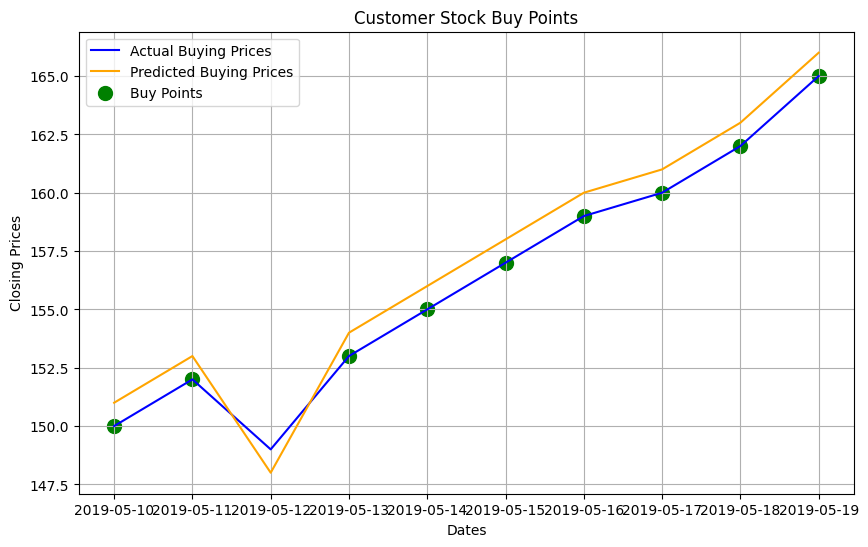

In [39]:

dates = pd.date_range(start='2019-05-10', periods=10, freq='D')
actual_prices = [150, 152, 149, 153, 155, 157, 159, 160, 162, 165]
predicted_prices = [151, 153, 148, 154, 156, 158, 160, 161, 163, 166]

buy_condition = [predicted > actual for actual, predicted in zip(actual_prices, predicted_prices)]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')

plt.plot(dates, actual_prices, 'b', label='Actual Buying Prices')
plt.plot(dates, predicted_prices, 'orange', label='Predicted Buying Prices')

buy_dates = [date for date, buy in zip(dates, buy_condition) if buy]
buy_prices = [price for price, buy in zip(actual_prices, buy_condition) if buy]
plt.scatter(buy_dates, buy_prices, color='green', marker='o', s=100, label='Buy Points')

plt.title('Customer Stock Buy Points')
plt.legend()
plt.show()
